In [236]:
import itertools
import pandas as pd
import numpy as np
import pylab
import statsmodels
import scipy

import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint
%pylab inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.weightstats import *

from statsmodels.sandbox.stats.multicomp import multipletests

Populating the interactive namespace from numpy and matplotlib


In [237]:
def write_answer(task, n_diff):
    with open(str(task)+".txt", "w") as fout:
        fout.write(str(n_diff))

In [238]:
data = pd.read_csv('credit_card_default_analysis.csv')

In [239]:
data.drop(['ID'], inplace=True, axis=1)

In [240]:
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,0,0,0,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,0,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,0,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### 1 Задание

#### Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы:

**a)** о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки

In [241]:
back = data[data['default']==0]
not_back = data[data['default']==1]

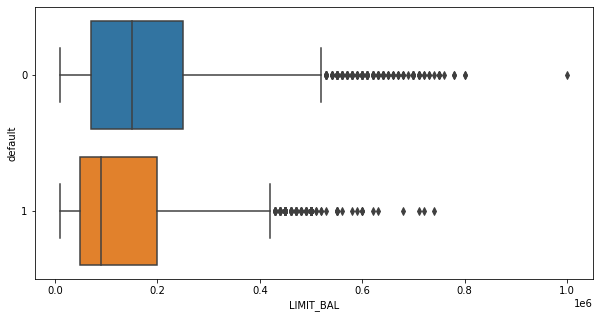

In [242]:
plt.figure(figsize=(10, 5))
sns.boxplot(data['LIMIT_BAL'], data['default'], orient='h');

Зрительно видно, что медианы отличаются. Проверим гипотезы с помощью статистики:
   * Н0: медианы равны
   * Н1: медианы не равны

Проверять данную гипотезу будем с помощью **бутстрепа**, тк распределение статистики 50% - квантиля нам неизвестно

In [243]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [244]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [245]:
np.random.seed(0)

back_median_scores = list(map(np.median, get_bootstrap_samples(back['LIMIT_BAL'].values, 1000)))
not_back_median_scores = list(map(np.median, get_bootstrap_samples(not_back['LIMIT_BAL'].values, 1000)))

print("95% confidence interval for returned:",  stat_intervals(back_median_scores, 0.05))
print("95% confidence interval for unreturned:",  stat_intervals(not_back_median_scores, 0.05))

95% confidence interval for returned: [150000. 150000.]
95% confidence interval for unreturned: [80000. 90000.]


#### Интервальная оценка медианных значений кредитного лимита позволяет отвергнуть нулевую гипотезу. Медианы не равны

Подтвердим это с помощью и интервальной оценки разности медиан

In [246]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(back_median_scores, not_back_median_scores)))

In [247]:
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [-70000. -60000.]


Интервальная оценка разности медиан показывает, что лимит кредита у невернувших значительно меньше, чем у возвративших, следовательно  **Н0 отвергаем**

***b)*** о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?


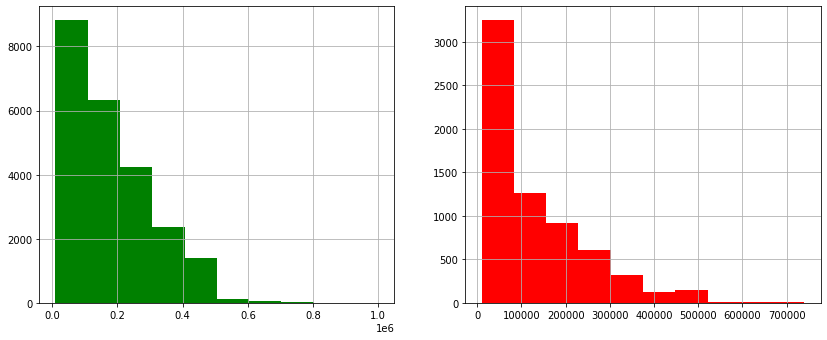

In [248]:
plt.figure(figsize=(14,12))
plt.subplot(2,2,1)
back['LIMIT_BAL'].hist(color='g')

plt.subplot(2,2,2)
not_back['LIMIT_BAL'].hist(color='r');

 Проверим гипотезы с помощью статистики:
   * Н0: распределения равны
   * Н1: распределения не равны

для анализа воспользуемся непараметрическим **ранговым критерием Манна-Уитни**

In [249]:
stats.mannwhitneyu(back['LIMIT_BAL'], not_back['LIMIT_BAL'])

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

Отвергаем нулевую гипотезу, следовательно, **распределния не равны**

### 2 Задание

Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

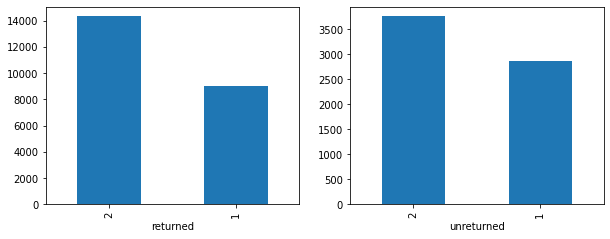

In [250]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
data[data['default']==0]['SEX'].value_counts().plot(kind='bar')
pylab.xlabel('returned')

plt.subplot(2,2,2)
data[data['default']==1]['SEX'].value_counts().plot(kind='bar')
pylab.xlabel('unreturned');

Проведём интервальные оценки для долей.

In [251]:
conf_interval_back = proportion_confint(sum(back['SEX'].map({2: 1, 1: 0})),
                                            data.shape[0],
                                            method = 'wilson')
conf_interval_not_back = proportion_confint(sum(not_back['SEX'].map({2: 1, 1: 0})),
                                            data.shape[0],
                                            method = 'wilson')

In [252]:
print('95%% confidence interval: [%f, %f]' % conf_interval_back)
print('95%% confidence interval: [%f, %f]' % conf_interval_not_back)

95% confidence interval: [0.472651, 0.483955]
95% confidence interval: [0.121733, 0.129229]


Можно заметить, что интервалы не пересекаются, значит соотношение полов различается

Проверим гипотезы с помощью z-критерием для разности долей:

* H0: гендерный состав групп не отличаются

* H1: составы отличаются

In [253]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)

    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2
    P = float(p1*n1 + p2*n2) / (n1 + n2)

    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")

    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))

    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [254]:
print("p-value: %s" % proportions_diff_z_test(proportions_diff_z_stat_ind(back['SEX'].map({2: 1, 1: 0}).values,
                                                                     not_back['SEX'].map({2: 1, 1: 0}).values)))

p-value: 4.472866521609831e-12


**p-value < 0.05 нулевая гипотеза отвергается, следовательно, гендерные составы отличаются**

### 3 Задание

Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг.

Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

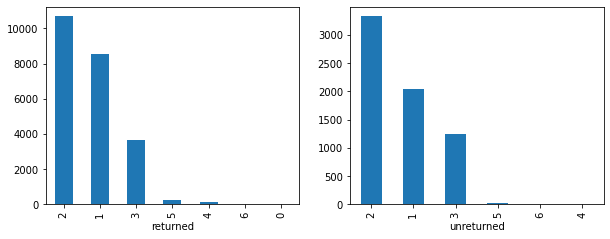

In [271]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
back['EDUCATION'].value_counts().plot(kind='bar')
pylab.xlabel('returned')

plt.subplot(2,2,2)
not_back['EDUCATION'].value_counts().plot(kind='bar')
pylab.xlabel('unreturned');

### Наблюдаемые частоты

In [256]:
observed_frequences_back = np.bincount(back['EDUCATION'])

In [257]:
observed_frequences_back

array([   14,  8549, 10700,  3680,   116,   262,    43], dtype=int64)

In [258]:
observed_frequences_not_back = np.bincount(not_back['EDUCATION'])

In [259]:
observed_frequences_not_back

array([   0, 2036, 3330, 1237,    7,   18,    8], dtype=int64)

### Таблица сопряженности частот и образования

In [260]:
conjugacy = pd.DataFrame(index=['доктор', 'магистр', 'бакалавр', 'выпускник школы',
                         'начальное образование', 'прочее', 'нет данных'])
#'education'- в роле индекса
conjugacy['observed_frequences_back'] = observed_frequences_back
conjugacy['observed_frequences_not'] = observed_frequences_not_back

In [261]:
conjugacy

,observed_frequences_back,observed_frequences_not
доктор,14,0
магистр,8549,2036
бакалавр,10700,3330
выпускник школы,3680,1237
начальное образование,116,7
прочее,262,18
нет данных,43,8


Проверим гипотезу о влиянии с помощью X^2 статистики:

* H0: образование не влияет

* H1: влияет


In [262]:
chi2, pvalue, dof, exp = stats.chi2_contingency(conjugacy)

In [263]:
print('Matthews significance p-value:', pvalue)

Matthews significance p-value: 1.2332626245415605e-32


**Отвергаем нулевую гипотезу на уровене значимости 0.05**

Добавляем ожидаемые частоты

In [264]:
expected_frequences_back = []
expected_frequences_not_back = []

for i in range(0,7):
    expected_frequences_back.append(exp[i][0])
    expected_frequences_not_back.append(exp[i][1])

In [268]:
expected_frequences_not_back

[3.0968, 2341.402, 3103.436, 1087.6404, 27.2076, 61.936, 11.2812]

In [269]:
expected_frequences_back

[10.9032, 8243.598, 10926.564, 3829.3596, 95.7924, 218.064, 39.7188]

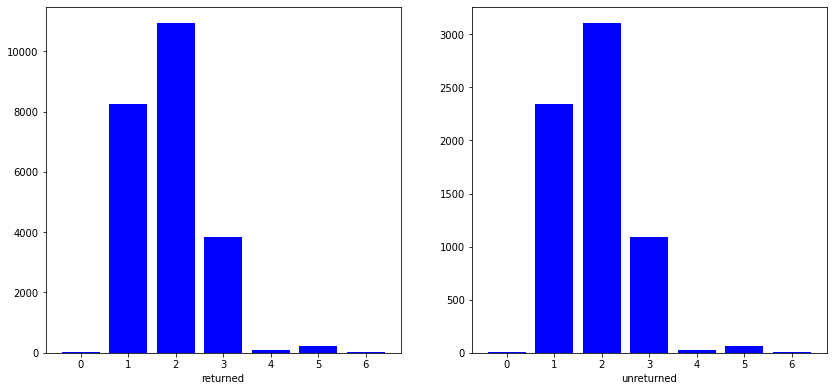

In [273]:
# графики для ожидаемых частот
plt.figure(figsize=(14,14))
plt.subplot(2,2,1)
pylab.bar(range(len(expected_frequences_back)), expected_frequences_back, color = 'b')
pylab.xlabel('returned')

plt.subplot(2,2,2)
pylab.bar(range(len(expected_frequences_not_back)), expected_frequences_not_back, color = 'b')
pylab.xlabel('unreturned');

In [274]:
between_frequences_back = np.round(observed_frequences_back - expected_frequences_back).astype(int)
between_frequences_not_back = np.round(observed_frequences_not_back - expected_frequences_not_back).astype(int)

Таблица сопряженности "образование" на "возврат долга", где значением ячейки  разность между наблюдаемым и ожидаемым количеством человек

In [277]:
conjugacy = pd.DataFrame(index=['доктор', 'магистр', 'бакалавр', 'выпускник школы',
                         'начальное образование', 'прочее', 'нет данных'])
conjugacy['between_frequences_back'] = between_frequences_back
conjugacy['between_frequences_not_back'] = between_frequences_not_back

In [278]:
conjugacy

,between_frequences_back,between_frequences_not_back
доктор,3,-3
магистр,305,-305
бакалавр,-227,227
выпускник школы,-149,149
начальное образование,20,-20
прочее,44,-44
нет данных,3,-3


Лучше всего возвращают кредиты магистры, а бакалавры и выпускники школ - хуже.

### 4 Задание

Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

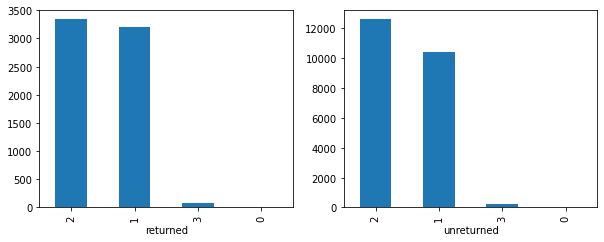

In [282]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
not_back['MARRIAGE'].value_counts().plot(kind='bar',)
pylab.xlabel('returned')

plt.subplot(2,2,2)
back['MARRIAGE'].value_counts().plot(kind='bar')
pylab.xlabel('unreturned');

In [287]:
data_marriage = pd.DataFrame()
data_marriage['marr_back'] = np.bincount(back['MARRIAGE'])
data_marriage['marr_not'] = np.bincount(not_back['MARRIAGE'])
data_marriage

,marr_back,marr_not
0,49,5
1,10453,3206
2,12623,3341
3,239,84


С помощью статистики Х^2 проверим справедливость гипотез:
   * H0: семейный статус не влияет на возврат

   * H1: семейный статус влияет

In [ ]:
x_2, p_value = stats.chi2_contingency(data_marriage)[:2]

In [294]:
print('Matthews significance p-value:', pvalue)

Matthews significance p-value: 1.2332626245415605e-32


На уровне 0.05 отвергаем нулевую гипотезу

Коэффициент взаимосвязи V-Крамера

In [293]:
np.sqrt(x_2/(sum(sum(data_marriage))*2))

0.024379771613073028

### 5 Задание

Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы:


**a**) о равенстве медианных значений возрастов людей

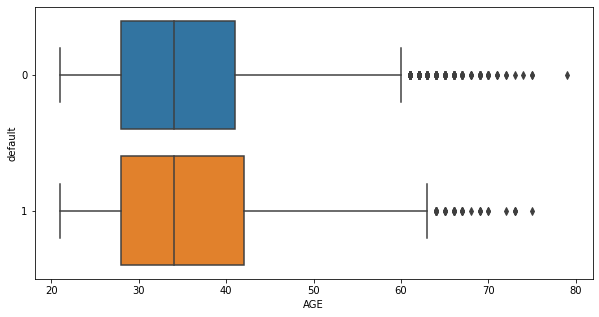

In [295]:
plt.figure(figsize=(10, 5))
sns.boxplot(data['AGE'], data['default'], orient='h');

Зрительно видно, что медианы равны. Проверим гипотезы с помощью статистики:
   * Н0: медианы равны
   * Н1: медианы не равны

In [296]:
np.random.seed(0)

age_back_median = list(map(np.median, get_bootstrap_samples(back['AGE'].values, 1000)))
age_not_back_median = list(map(np.median, get_bootstrap_samples(not_back['AGE'].values, 1000)))

print("95% confidence interval for returned:",  stat_intervals(age_back_median, 0.05))
print("95% confidence interval for unreturn:",  stat_intervals(age_not_back_median, 0.05))

95% confidence interval for returned: [34. 34.]
95% confidence interval for didn't return: [34. 35.]


Интервальная оценка медианных значений кредитного лимита не дает отвергнуть нулевую гипотезу, так как интервалы пересекаются

In [297]:
delta_median_age = list(map(lambda x: x[1] - x[0], zip(age_back_median, age_not_back_median)))

In [298]:
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_age, 0.05))

95% confidence interval for the difference between medians [0. 1.]


Интервальная оценка разности медиан также подтверждает, что Н0 отвергнуть нельзя. Она содержит 0.

b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

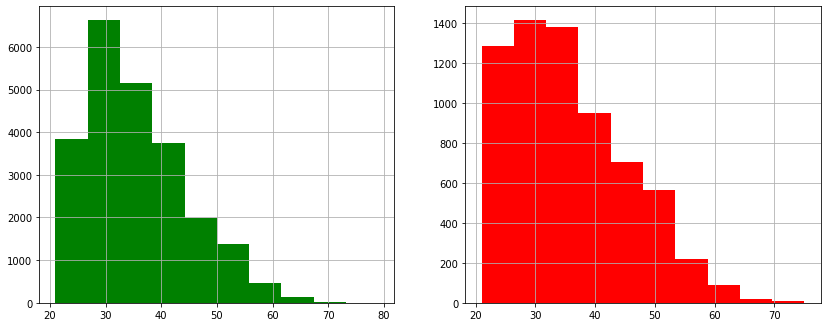

In [299]:
plt.figure(figsize=(14,12))
plt.subplot(2,2,1)
back['AGE'].hist(color='g')

plt.subplot(2,2,2)
not_back['AGE'].hist(color='r');

Проверим гипотезы с помощью критерия Манна-Уитни:

* Н0: распределения равны

* Н1: распределения не равны

In [300]:
stats.mannwhitneyu(back['AGE'], not_back['AGE'])

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

**Отвергнуть нулевую гипотезу нельзя**

